In [12]:
import ast
import pickle
from collections import Counter
from pathlib import Path
from time import gmtime, strftime
from typing import Any, Union

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm.notebook import tqdm

from preprocess_functions import build_tree, extract_keys, map_targets

In [2]:
RANDOM_STATE = 42
TEST_SIZE = 0.2

In [3]:
COLAB_DIR = Path('/content/drive/MyDrive')
KAGGLE_DIR = Path('/kaggle/input')
LOCAL_DIR = Path('./')

try:
    import google.colab

    IN_COLAB = True
except ImportError:
    IN_COLAB = False

try:
    import kaggle_secrets

    IN_KAGGLE = True
except ImportError:
    IN_KAGGLE = False

if IN_COLAB:
    DATA_DIR = COLAB_DIR / 'data'
    MODELS_DIR = COLAB_DIR / 'models'
elif IN_KAGGLE:
    DATA_DIR = KAGGLE_DIR
    MODELS_DIR = KAGGLE_DIR
else:
    DATA_DIR = LOCAL_DIR / 'data'
    MODELS_DIR = LOCAL_DIR / 'models'

In [26]:
DATASET_DIR = DATA_DIR
THREAT_TWEETS_CSV = DATASET_DIR / 'tweets_final.csv'

In [5]:
filter_df = (
    pd.read_csv(filepath_or_buffer=THREAT_TWEETS_CSV)
    #.query(expr='relevant == True') # Commented for creating the dataset of the filter
)
filter_df.dropna(subset=['relevant'])
print(f"There are {filter_df.shape[0]} tweets")
filter_df.head()

There are 21368 tweets


,_id,date,id,relevant,text,tweet,type,watson,annotation,urls,destination_url,valid_certificate
0,b'5b88752abb325e65390af240',2018-08-30 22:52:25+00:00,1035299228984041472,False,Best way to build empathy is through honesty a...,{'created_at': 'Thu Aug 30 22:52:25 +0000 2018...,vulnerability,"{'usage': {'text_units': 1, 'text_characters':...",irrelevant,[],NaN,NaN
1,b'5b8875d5bb325e65a22cf81b',2018-08-30 22:55:15+00:00,1035299941932036096,False,Cryptocurrency Scams Replacing Ransomware as A...,{'created_at': 'Thu Aug 30 22:55:15 +0000 2018...,ransomware,"{'usage': {'text_units': 1, 'text_characters':...",business,['https://ubm.io/2MCQwfg'],https://www.darkreading.com/endpoint-security,False
2,b'5b88768dbb325e65fa7e78e3',2018-08-30 22:58:20+00:00,1035300715470757889,False,Cryptocurrency Scams Replacing Ransomware as A...,{'created_at': 'Thu Aug 30 22:58:20 +0000 2018...,ransomware,"{'usage': {'text_units': 1, 'text_characters':...",business,['http://quantus.biz/security/2018/08/30/crypt...,http://www.quantusintel.group/,True
3,b'5b8876f9bb325e65fa7e78e4',2018-08-30 23:00:08+00:00,1035301167952211969,True,Protect your customers access Prestashop Ant...,{'created_at': 'Thu Aug 30 23:00:08 +0000 2018...,ddos,"{'usage': {'text_units': 1, 'text_characters':...",threat,['http://addons.prestashop.com/en/23513-anti-d...,https://addons.prestashop.com/en/23513-anti-dd...,True
4,b'5b8876f9bb325e65fa7e78e5',2018-08-30 23:00:09+00:00,1035301173178249217,True,Data leak from Huazhu Hotels may affect 130 mi...,{'created_at': 'Thu Aug 30 23:00:09 +0000 2018...,leak,"{'usage': {'text_units': 1, 'text_characters':...",threat,['http://www.hotelmanagement.net/tech/data-lea...,http://www.hotelmanagement.net/tech/data-leak-...,True


In [6]:
X_train_val, X_test = train_test_split(
    filter_df,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=filter_df['relevant']
)

X_train_val.shape, X_test.shape

((17094, 12), (4274, 12))

In [7]:
with open(DATASET_DIR / 'filter_train.pkl', 'wb') as f:
    pickle.dump(X_train_val, f)

with open(DATASET_DIR / 'filter_test.pkl', 'wb') as f:
    pickle.dump(X_test, f)

In [8]:
with open(DATASET_DIR / 'filter_train.pkl', 'rb') as f:
    X_train = pickle.load(file=f)
with open(DATASET_DIR / 'filter_test.pkl', 'rb') as f:
    X_test = pickle.load(file=f)
X_train.shape, X_test.shape

((17094, 12), (4274, 12))

In [7]:
FIX_TARGETS = {
    'computer security': 'computer security',
    'operating systems': 'operating systems',
    'software': 'software',
    'programming languages': 'software',
    'hardware': 'hardware',
    'electronic components': 'hardware',
    'networking': 'networking',
    'internet technology': 'networking',
    #'network security': 'network security',
    'antivirus and malware': 'antivirus and malware',
    #'mac os': 'mac os',
    #'windows': 'windows',
    #'unix': 'unix',
    #'linux': 'linux',
    #'databases': 'databases',
    'computer': 'computer',
    #'computer components': 'computer components',
    #'computer networking': 'computer networking',
    #'servers': 'servers',
    #'portable computer': 'portable computer',
    #'desktop computer': 'desktop computer',
    #'router': 'router',
    #'wireless technology': 'wireless technology'
}

categories_df = (
    pd.read_csv(filepath_or_buffer=THREAT_TWEETS_CSV)
    .assign(
        tweet=lambda df: df['tweet'].apply(func=ast.literal_eval),
        watson=lambda df: df['watson'].apply(func=ast.literal_eval)
        .apply(func=lambda x: x.get('categories', []))
        .apply(func=build_tree),
        watson_list=lambda df: df['watson'].apply(func=extract_keys),
        target=lambda df: df['watson_list'].apply(func=map_targets, args=(FIX_TARGETS,))
    )
    #.query(expr='relevant == True')
)
mask = ['other' in target_i for target_i in categories_df['target']]
categories_df_temp = categories_df[mask]
categories_df_temp = categories_df_temp[categories_df_temp['relevant'] == False]
categories_df = categories_df.loc[list(set(categories_df.index) - set(categories_df_temp.index))]
categories_df = categories_df.reset_index(drop=True)

print(f"There are {categories_df.shape[0]} tweets")
categories_df.head()

There are 15610 tweets


,_id,date,id,relevant,text,tweet,type,watson,annotation,urls,destination_url,valid_certificate,watson_list,target
0,b'5b88752abb325e65390af240',2018-08-30 22:52:25+00:00,1035299228984041472,False,Best way to build empathy is through honesty a...,{'created_at': 'Thu Aug 30 22:52:25 +0000 2018...,vulnerability,{'science': {'social science': {'philosophy': ...,irrelevant,[],NaN,NaN,"[science, social science, philosophy, ethics, ...",[computer security]
1,b'5b8875d5bb325e65a22cf81b',2018-08-30 22:55:15+00:00,1035299941932036096,False,Cryptocurrency Scams Replacing Ransomware as A...,{'created_at': 'Thu Aug 30 22:55:15 +0000 2018...,ransomware,{'technology and computing': {'computer securi...,business,['https://ubm.io/2MCQwfg'],https://www.darkreading.com/endpoint-security,False,"[technology and computing, computer security, ...","[antivirus and malware, hardware, computer sec..."
2,b'5b88768dbb325e65fa7e78e3',2018-08-30 22:58:20+00:00,1035300715470757889,False,Cryptocurrency Scams Replacing Ransomware as A...,{'created_at': 'Thu Aug 30 22:58:20 +0000 2018...,ransomware,{'technology and computing': {'computer securi...,business,['http://quantus.biz/security/2018/08/30/crypt...,http://www.quantusintel.group/,True,"[technology and computing, computer security, ...","[antivirus and malware, hardware, computer sec..."
3,b'5b8876f9bb325e65fa7e78e4',2018-08-30 23:00:08+00:00,1035301167952211969,True,Protect your customers access Prestashop Ant...,{'created_at': 'Thu Aug 30 23:00:08 +0000 2018...,ddos,{'technology and computing': {'internet techno...,threat,['http://addons.prestashop.com/en/23513-anti-d...,https://addons.prestashop.com/en/23513-anti-dd...,True,"[technology and computing, internet technology...","[antivirus and malware, computer security, net..."
4,b'5b8876f9bb325e65fa7e78e5',2018-08-30 23:00:09+00:00,1035301173178249217,True,Data leak from Huazhu Hotels may affect 130 mi...,{'created_at': 'Thu Aug 30 23:00:09 +0000 2018...,leak,"{'travel': {'hotels': {}}, 'home and garden': ...",threat,['http://www.hotelmanagement.net/tech/data-lea...,http://www.hotelmanagement.net/tech/data-leak-...,True,"[travel, hotels, home and garden, home improve...",[other]


Target Frequencies:
computer security: 9216
antivirus and malware: 5854
software: 5214
hardware: 2998
other: 2255
computer: 2210
networking: 1340
operating systems: 1271


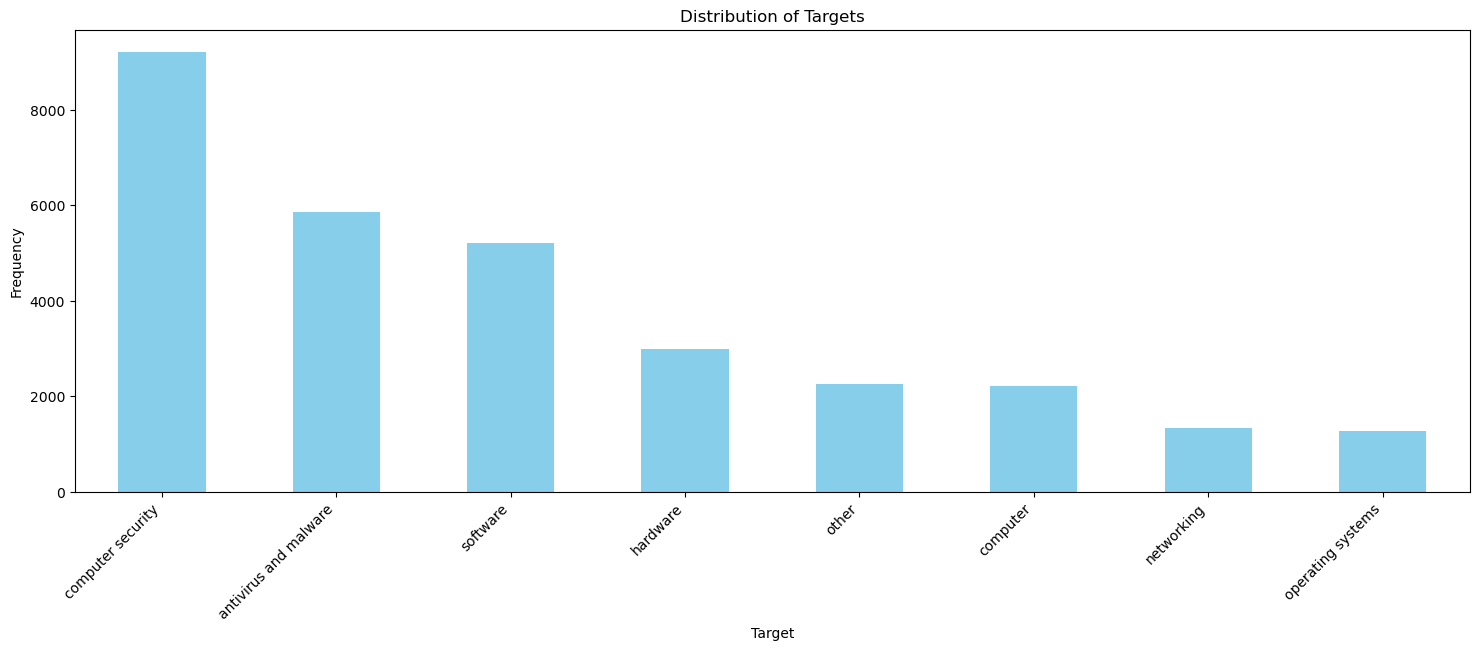

In [8]:
class_freq = Counter([item for sublist in categories_df['target'] for item in sublist])

print("Target Frequencies:")
for target, freq in class_freq.most_common():
    print(f"{target}: {freq}")

_, ax = plt.subplots(figsize=(18, 6))
pd.Series(data=class_freq).sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Distribution of Targets')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()

Target Frequencies:
('antivirus and malware', 'computer security'): 2407
('other',): 2255
('computer security',): 2138
('software',): 1172
('antivirus and malware', 'computer security', 'software'): 1076
('computer security', 'software'): 682
('computer security', 'antivirus and malware'): 613
('hardware', 'computer'): 563
('antivirus and malware', 'hardware', 'computer security', 'computer'): 535
('networking',): 382
('software', 'operating systems'): 358
('hardware', 'computer', 'software'): 353
('hardware',): 319
('software', 'antivirus and malware', 'computer', 'hardware', 'computer security'): 268
('networking', 'software'): 204
('operating systems',): 202
('hardware', 'software'): 182
('antivirus and malware', 'computer security', 'networking', 'software'): 175
('antivirus and malware', 'software', 'computer security', 'operating systems'): 132
('computer security', 'antivirus and malware', 'software'): 124
('computer security', 'hardware', 'computer'): 115
('antivirus and malwar

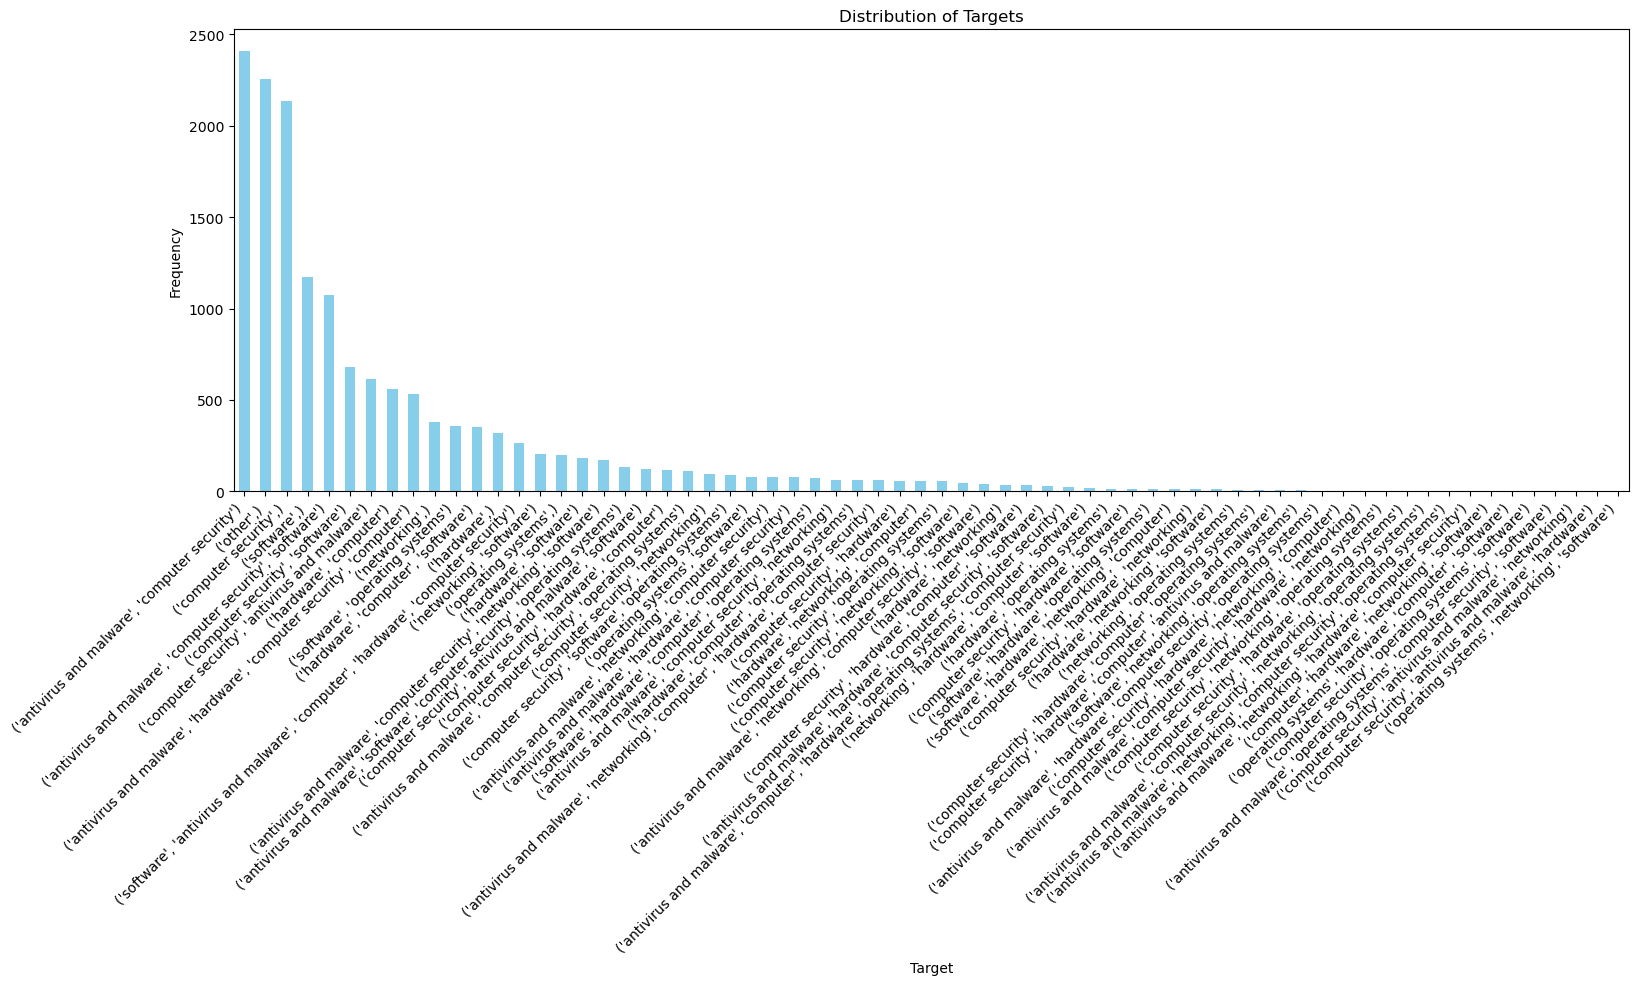

Number of targets to subsample:	19


In [9]:
target_freq = Counter(tuple(item) for item in categories_df['target'])
cut = len(target_freq)

print("Target Frequencies:")
for target, freq in target_freq.most_common()[:cut]:
    print(f"{target}: {freq}")

_, ax = plt.subplots(figsize=(18, 6))

(pd.Series(data={str(k): v for k, v in target_freq.most_common()[:cut]})
 .sort_values(ascending=False)
 .plot(kind='bar', color='skyblue'))

plt.title('Distribution of Targets')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()
print(f'Number of targets to subsample:\t{sum([1 if v < 10 else 0 for v in target_freq.values()])}')

In [13]:
def prune_and_subsample(
        x: pd.DataFrame,
        y: list[list[Any]],
        pruning_threshold: float,
        max_sub_samples: int
) -> tuple[
    np.ndarray[Any, np.dtype],
    np.ndarray[Any, np.dtype],
    dict[int, Union[tuple[Any, ...], tuple[int, ...]]],
    np.ndarray[Any, np.dtype]
]:
    """
    Prune and subsample the given samples.

    Parameters
    ----------
    x
    y
    pruning_threshold
    max_sub_samples

    Returns
    -------

    """
    # Count occurrences of each label set
    label_counts = Counter(tuple(lbl_set) for lbl_set in y)
    frequent_label_sets = {k for k, v in label_counts.items() if v >= pruning_threshold}
    x_new = []
    y_new = []
    index_mapping = []
    label_map = {}
    class_idx = 0

    for idx, lbl_set in enumerate(tqdm(y)):
        lbl_tuple = tuple(lbl_set)

        if lbl_tuple in frequent_label_sets:
            # Preserve frequent label sets
            if lbl_tuple not in label_map:
                label_map[lbl_tuple] = class_idx
                class_idx += 1

            x_new.append(x.loc[idx])
            y_new.append(label_map[lbl_tuple])
            index_mapping.append(idx)
        else:
            # Subsample infrequent label sets
            lbl_subsets = []

            for i in range(2 ** len(lbl_tuple)):
                lbl_subset = tuple((lbl_tuple[j] if (i >> j) & 1 else 0) for j in range(len(lbl_tuple)))
                lbl_subsets.append(lbl_subset)

            lbl_subsets = [subset for subset in lbl_subsets if subset in frequent_label_sets]
            lbl_subsets = lbl_subsets[:max_sub_samples]

            for subset in lbl_subsets:
                if subset not in label_map:
                    label_map[subset] = class_idx
                    class_idx += 1

                x_new.append(x.loc[idx])
                y_new.append(label_map[subset])
                index_mapping.append(idx)

    return np.array(x_new), np.array(y_new), {v: k for k, v in label_map.items()}, np.array(index_mapping)

In [14]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y=categories_df['target'])
labels_map, _ = np.unique(ar=y, axis=0, return_inverse=True)

In [15]:
X_pst, y_pst, label_map_pst, _ = prune_and_subsample(
    x=categories_df,
    y=y,
    pruning_threshold=round(TEST_SIZE ** -1),
    max_sub_samples=round(TEST_SIZE ** -1)
)

  0%|          | 0/15610 [00:00<?, ?it/s]

In [16]:
target = pd.Series(data=[list(mlb.classes_[labels_map[yi] == 1]) for yi in y_pst], name='target')
_, y_mcp = np.unique(ar=mlb.transform(target), axis=0, return_inverse=True)
X_train_val, X_test = train_test_split(
    X_pst,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    shuffle=True,
    stratify=y_mcp
)

In [27]:
with open(DATASET_DIR / f'categories train {strftime("%Y-%m-%d_%H:%M:%S", gmtime())}.pkl', 'wb') as f:
    pickle.dump(X_train_val, f)

with open(DATASET_DIR / f'categories test {strftime("%Y-%m-%d_%H:%M:%S", gmtime())}.pkl', 'wb') as f:
    pickle.dump(X_test, f)